In [ ]:
import torch;
import tiktoken;
import torch
import torch.nn as nn
import math


from MyTransformer import MyGPTModel;

torch.manual_seed(123)



GPT_CONFIG = {
    "vocab_size": 50257,    #词汇表大小
    "max_seq_length": 256, #每一句训练数据的最大长度
    "embedding_dim": 768,   #嵌入向量的维度
    "n_heads": 12,          #注意力头个数
    "n_layers": 12,         #Transformer 层数
    "drop_rate": 0.1,       #Dropout rate
    "qkv_bias": False       #bias
}

#torch.manual_seed(123)
model = MyGPTModel(GPT_CONFIG)

x = torch.tensor([[1,2,3], [6666,7777,888]])
out = model(x)
print("Input data:\n", x)
print("\nOutput shape:", out.shape)
print(out)

# 一、 推理

In [ ]:

# 
# max_new_tokens 生成文本的最大个数
# 文本上下文的大小
def generate_text(model, prompt, max_new_tokens, context_seq_size):
    for  _ in range(max_new_tokens):
        # 最大限制额 1024 
        prompt_slice = prompt[:, -context_seq_size:];
        # 创建pytorch的上下文管理器  作用是： 禁止梯度计算
        with torch.no_grad():
            # logits 嵌入向量矩阵
            logits = model(prompt);

        # 从logits中拿到最后一位
        # logits[batch_size, new_token, vocab_size];
        logits = logits[:, -1, :];

        probas = torch.softmax(logits, dim=1);

        # 得到最大概率的位置 
        new_token = torch.argmax(probas, dim=-1, keepdim=True);

        # 
        prompt = torch.cat((prompt, new_token), dim=1);
    return prompt;

# 二、 编码向量

In [ ]:
#  文本转token
def text_to_tokenids(text, tokenizer):
    encoded = tokenizer.encode(text);
    encoded_new = torch.tensor(encoded).unsqueeze(0); #  在新生成的tensor的最前面增加一个新tensor
    return encoded_new;

# token 转文本
def tokenids_to_text(tokenids, tokenizer):
    token_new = tokenids.squeeze(0); # 它会将tokenids中最前一个维度位1去了  [[1, 2, 3]]
    return tokenizer.decode(token_new.tolist());

In [ ]:

# 设置推理模式
model.eval();


#  设置提示词
prompt = "北京的最高山是?";  # 东灵山

tokenizer = tiktoken.get_encoding("gpt2");




prpt = text_to_tokenids(prompt, tokenizer);

token_ids = generate_text(model=model, 
              prompt=prpt, 
              max_new_tokens=10, 
              context_seq_size=256, #每一句训练数据的最大长度
              );



print(tokenids_to_text(token_ids, tokenizer));

# 三、文本评估

1. 这与深度学习中的监督学习是一个道理
2. 通过模型预测结果， 然后将结果与"答案"比较
3. <font color='red'>评估</font>预测结果与"答案“之间的差距
4. 差距小，做小惩罚
5. 反之， 差距大做大的惩罚




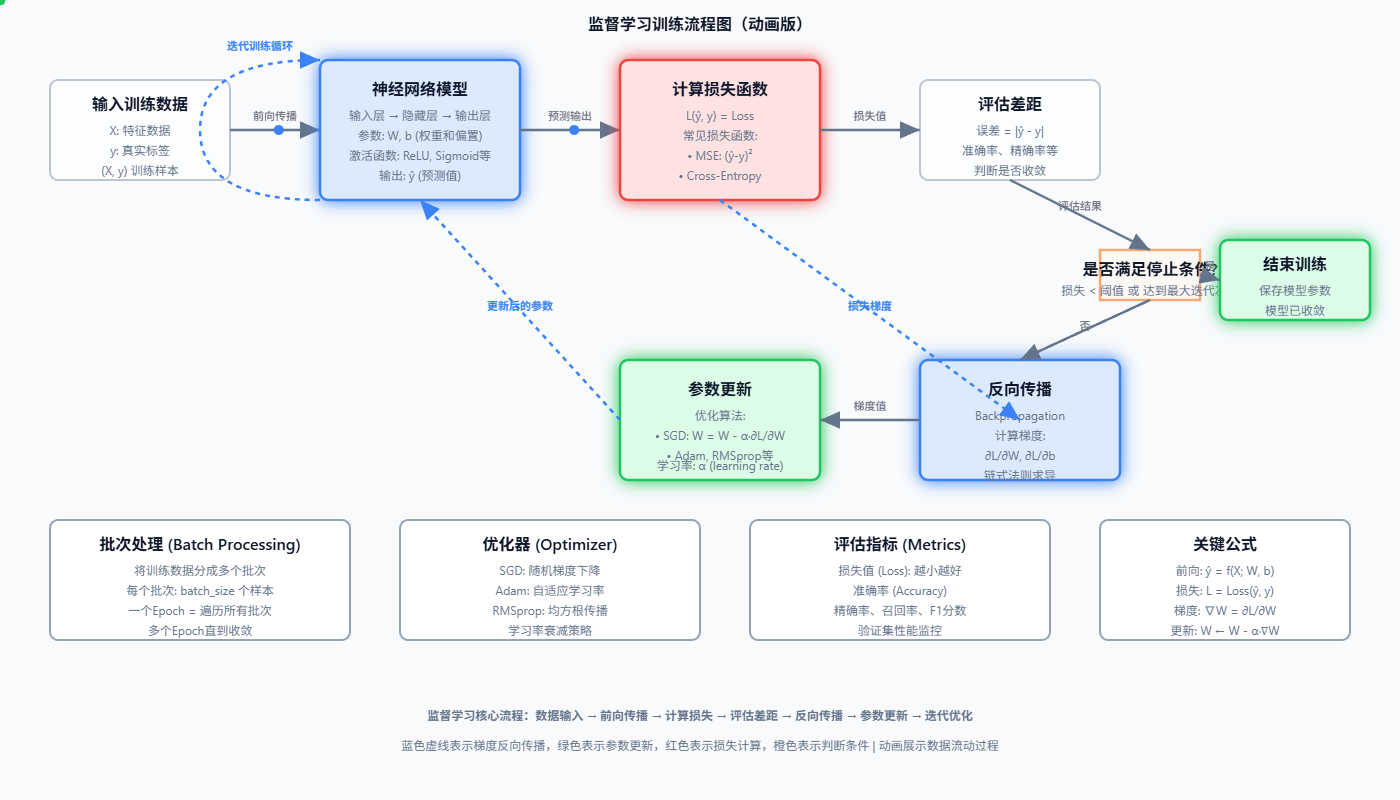


## 3.1、评估的方法

1. 最直接的办法: 1- ("答案"的概率)
2. 如果答案的概率是0.01， 那评估的损失为1-0.01=0.99
3. 这样计算最小损失是0， 最大损失是0.99。【0-1】
4. 这种评估方法的弊端,<font color='red'> 区分度不够明显</font>


## 3.2  更好的方法

1. 对数惩罚:(-log(p))， 是个好方法
2. 特性1:当模型预测正确答案的概率高时（0.99），结果为0
3. 特性2：当模型预测正确答案的概率低时（0.01）， 结果很大
4. 当结果预测的越离谱，惩罚的越狠
5. 1 - p和-log（p）相比， 后者能更有效地驱动模型学习


## 3.3 如何取出每个token "答案"的概率？


target_probas_0 = probas[0, [0, 1, ...], targets[0]];

1. probas的形状是: batch_size, token个数， vocab_size
2. targets[0]: 第一个训练样本中预测token的答案(tokenID)
3. probas[0, idx]: 第一个训练样本中第idx项token


## 3.4 计算实际损失

1. p = torch.cat((target_probas_0, target_probas_1, ...)); # 正确值的概率统计
2. loss = - torch.log(p).mean();
3. 计算粗的loss是一个数值， 即每个训练次得到一个损失值



In [ ]:
inputs = torch.tensor([[34534, 34543, 342], [4, 3, 1]]);
targets = torch.tensor([[34543, 342, 897], [3, 1, 9]]);

# 设置推理模式
model.eval();

# 禁止使用梯度下降
with  torch.no_grad():
    logits = model(inputs);

print("Logits shape: ", logits.shape);
print("targets shape:", targets.shape);


# 起始维度和 终始的维度 两个维度合并
logits = logits.flatten(0, 1);
targets = targets.flatten(); # 默认


print("Logits shape: ", logits.shape);
print("targets shape:", targets.shape);


# 损失
loss = torch.nn.functional.cross_entropy(logits, target=targets);

print("loss:", loss);

In [ ]:
from data import create_dataloader;


with open("../02.文本与分词/the-verdict.txt", "r", encoding='utf-8') as f:
    text_data = f.read();


print(len(text_data));


ratio = 0.9 ;

# 训练数据 
train_data_length = int(ratio * len(text_data));
train_data = text_data[0:train_data_length];

# vaild验证 数据
val_data = text_data[train_data_length:];

print("tran data len : ", len(train_data), "val data len : ", len(val_data));

# 训练数据loader
train_loader =  create_dataloader(
    text=train_data,
   bz=2,
    max_length=GPT_CONFIG["max_seq_length"],
    stride=GPT_CONFIG["max_seq_length"],
    drop_last=True,
    shuffle=True,
    worker_num=0,
);


# 验证数据loader

val_loader = create_dataloader(
    text=val_data,
    bz=2 ,
    max_length=GPT_CONFIG["max_seq_length"],
    stride=GPT_CONFIG["max_seq_length"],
    drop_last=False,
    shuffle=False,  
    worker_num=0,
);


print(f"train_loader:{train_loader}");


 获取当前x，y信息
 
 # <font color='red'>通过Dataloader获取数据的方式</font>

1. 训练时， 我们一般通过for循环从Dataloader中获取数据
2. 通过iterater+next获取一个批次的样本， 主要用于验证


In [ ]:


for x, y in train_loader:
    print(x.shape, y.shape);



In [ ]:
data_iter = iter(train_loader);


batch = next(data_iter);

x, y = next(data_iter);



# print(f"batch:{batch}");

print(f"x.shape:{x.shape}, y.shape:{y.shape}");